In [23]:
%matplotlib inline
from time import time, sleep
import numpy as np
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt

from IPython import display

In [24]:

# load layers, activation function, dropout
%run homework_modules.ipynb

In [25]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1

In [26]:
import keras
from keras.datasets import mnist

In [27]:
(x_train, target_train), (x_test, target_test) = mnist.load_data()


x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(target_train, 10)
y_test = keras.utils.to_categorical(target_test, 10)

num = 10

print ('Training size:', x_train.shape[0])
print ('Test size:', x_test.shape[0])

Training size: 60000
Test size: 10000


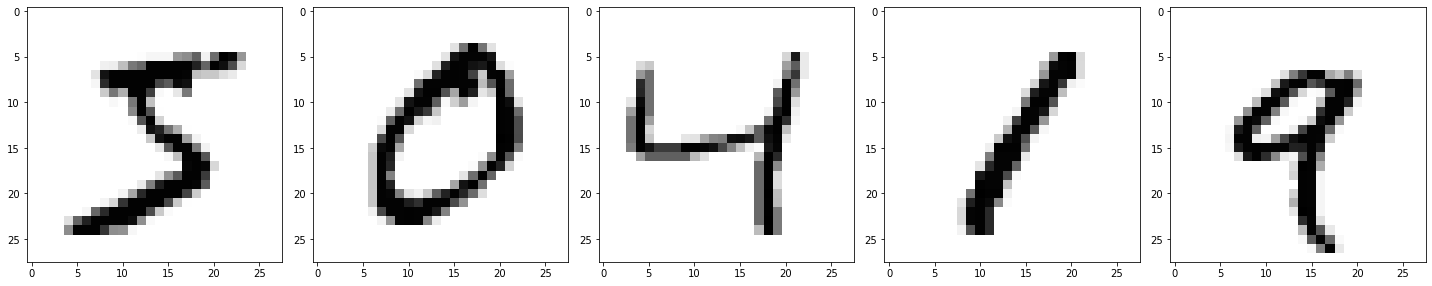

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(20,15))
axes = axes.flatten()
for img, ax in zip(x_train[:5].reshape((-1,28,28)), axes):
    ax.imshow(img, cmap="Greys")
plt.tight_layout()
plt.show()

In [29]:
# build neural network
# neural_model = Sequential()
# neural_model.add(Linear(x_train.shape[1], 400))
# neural_model.add(ReLU())
# neural_model.add(Dropout(0.8))
# neural_model.add(Linear(400, 100))
# neural_model.add(Sigmoid())
# neural_model.add(Linear(100, 10))
# neural_model.add(SoftMax())

# crit = MSECriterion()

# print(neural_model)

neural_model = Sequential()
neural_model.add(Linear(x_train.shape[1], 500))
neural_model.add(ReLU())
neural_model.add(Dropout(0.6))
neural_model.add(Linear(500, 100))
neural_model.add(Sigmoid())
neural_model.add(Dropout(0.5))
neural_model.add(Linear(100, num))
neural_model.add(SoftMax())

crit = MSECriterion()

print(neural_model)

Linear 784 -> 500
ReLU
Dropout
Linear 500 -> 100
Sigmoid
Dropout
Linear 100 -> 10
SoftMax



In [30]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 100

In [31]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [32]:
train_loss_history = []
test_loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((x_train, y_train), batch_size):
        
        neural_model.zeroGradParameters()
        
        # Forward
        predictions = neural_model.forward(x_batch)
        loss = crit.forward(predictions, y_batch)
    
        # Backward
        dp = crit.backward(predictions, y_batch)
        neural_model.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(neural_model.getParameters(), 
                     neural_model.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        train_loss_history.append(loss)
    
    # Test
    test_pred = neural_model.forward(x_test)
    test_loss = crit.forward(test_pred, y_test)
    test_loss_history.append(test_loss)
    
    # Accuracy
    hits = 0
    for prediction, label in zip(test_pred, target_test):
        if np.argmax(prediction) == label:
            hits += 1
    accuracy = hits / len(target_test) * 100
    epoch_time = np.arange(0, len(train_loss_history), dtype=float) / (y_train.shape[0] // batch_size)
    
    print('Epoch: %f' % i)
    print('Train loss: %f' % loss)
    print('Test loss: %f' % test_loss)
    print('Test accuracy: %f' % accuracy)

Epoch: 0.000000
Train loss: 0.417763
Test loss: 0.335319
Test accuracy: 80.430000
Epoch: 1.000000
Train loss: 0.129541
Test loss: 0.165321
Test accuracy: 89.600000
Epoch: 2.000000
Train loss: 0.110115
Test loss: 0.144151
Test accuracy: 91.440000
Epoch: 3.000000
Train loss: 0.141947
Test loss: 0.101948
Test accuracy: 93.410000
Epoch: 4.000000
Train loss: 0.071537
Test loss: 0.113138
Test accuracy: 93.160000
Epoch: 5.000000
Train loss: 0.086168
Test loss: 0.099748
Test accuracy: 93.830000
Epoch: 6.000000
Train loss: 0.094195
Test loss: 0.093450
Test accuracy: 94.140000
Epoch: 7.000000
Train loss: 0.140089
Test loss: 0.075401
Test accuracy: 95.230000
Epoch: 8.000000
Train loss: 0.078308
Test loss: 0.065411
Test accuracy: 95.990000
Epoch: 9.000000
Train loss: 0.057468
Test loss: 0.074754
Test accuracy: 95.330000


Current train loss: 0.057468
Current test loss: 0.074754
Current test accuracy: 95.330000


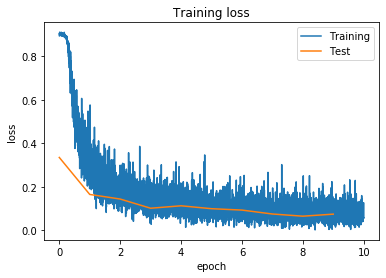

In [33]:
# Visualize

plt.plot(epoch_time, train_loss_history)
plt.plot(test_loss_history)

plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Test'], loc= 'upper right')

print('Current train loss: %f' % loss)
print('Current test loss: %f' % test_loss)
print('Current test accuracy: %f' % accuracy)